# Explore SDSSRM-XCS Scatter: Jackknifing to assess $M_{\rm{tot}}$-$\lambda_{\rm{RM}}$

This section of the project explores potential reasons and diagnostics of galaxy cluster/group scaling relation scatter using the new SDSSRM-XCS relations constructed in this work from the properties measured in the first paper of this series [(Turner et al. 2024)](https://ui.adsabs.harvard.edu/abs/2025MNRAS.tmp...10T/abstract).

Here we particularly focus on using the common 'jackknife' re-sampling technique in an attempt to identify particular clusters that are the dominant cause of a large scatter measurement for some of our more important scaling relations. Such data points (if they are present) may be genuine measurement outliers, caused by some fitting failure or analysis problem for an individual cluster in the first paper of this series. They may also be clusters that _are_ intrinsically more scattered. 

Scaling relation fits were performed using the XGA interface to the R scaling-relation fitting package LIRA, see the paper for full details.

## Main takeaways

In summary:

* **<span style="color:red">.......</span>**

## Import Statements 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM
import pickle
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xcs_cosmo, m_norm, rich_norm, leave_one_jackknife

import xga
from xga.relations.fit import scaling_relation_lira

# Setting up this constant that controls the confidence intervals calculated for the scatter change
#  distributions - makes it much easier to change the exact value later if we need too. This is 
#  what is going to be used to define the scatter-dominating clusters.
CONF_PERC = 90

## Loading data files and relations

We load the 'base' SDSSRM-XCS sample file, containing some basic information about galaxy cluster names, positions, and redshifts. We also load the SDSSRM-XCS cluster property results files from the first paper of this series. 

The scaling relations which we are performing our bootstrapping scatter assessment on are also loaded in here.

### SDSSRM-XCS base sample

In [2]:
sdssxcs_base = pd.read_csv("../../sample_files/SDSSRM-XCS_base_sample.csv")
sdssxcs_base.head(6)

,name,MEM_MATCH_ID,xapa_ra,xapa_dec,rm_ra,rm_dec,z,r500,r500-,r500+,richness,richness_err,XCS_NAME,R_LAMBDA,xmm_targeted,xmm_serendipitous
0,SDSSXCS-124,124,0.80058,-6.09182,0.798261,-6.091694,0.2475,1181.028,21.202,23.203,109.550,4.490,XMMXCS J000312.1-060530.5,1.018410,True,False
1,SDSSXCS-2789,2789,0.95554,2.06802,0.956981,2.066469,0.1053,1007.861,17.194,17.202,38.904,2.830,XMMXCS J000349.3+020404.8,0.827942,True,False
2,SDSSXCS-290,290,2.72264,29.16102,2.714137,29.161154,0.3485,913.052,30.879,31.210,105.096,5.994,XMMXCS J001053.4+290939.6,1.009990,True,False
3,SDSSXCS-1018,1018,4.40633,-0.87619,4.406711,-0.878340,0.2144,902.259,22.445,23.366,56.997,3.219,XMMXCS J001737.5-005234.2,0.893655,False,True
4,SDSSXCS-134,134,4.90839,3.60982,4.911069,3.599257,0.2773,1123.321,19.219,19.226,108.604,4.792,XMMXCS J001938.0+033635.3,1.016645,True,False
5,SDSSXCS-119,119,8.46470,-7.86290,8.471426,-7.869543,0.3042,944.275,46.422,46.747,128.192,5.697,XMMXCS J003351.5-075146.4,1.050926,True,False


Calculating E(z) values for these clusters:

In [3]:
sdssxcs_base['E'] = xcs_cosmo.efunc(sdssxcs_base['z'].values)

### SDSSRM-XCS $T_{\rm{X}}$ and $L_{\rm{X}}$

In [4]:
sdssxcs_txlx = pd.read_csv("../../sample_files/paper_one_results/sdssrm-xcs_txlx_v1.0.0.csv")
sdssxcs_txlx.head(6)

,name,Tx_500,Tx_500-,Tx_500+,Lx52_500,Lx52_500-,Lx52_500+,Lxbol_500,Lxbol_500-,Lxbol_500+,Tx_2500,Tx_2500-,Tx_2500+,Lx52_2500,Lx52_2500-,Lx52_2500+,Lxbol_2500,Lxbol_2500-,Lxbol_2500+,Tx_500ce,Tx_500ce-,Tx_500ce+,Lx52_500ce,Lx52_500ce-,Lx52_500ce+,Lxbol_500ce,Lxbol_500ce-,Lxbol_500ce+
0,SDSSXCS-124,6.92000,0.116389,0.111642,5.310408e+44,2.494586e+42,3.193270e+42,2.039754e+45,2.082091e+43,1.712354e+43,7.08946,0.097823,0.097929,4.008461e+44,2.163312e+42,1.887667e+42,1.557705e+45,1.278003e+43,1.166420e+43,6.78098,0.134306,0.158223,3.684827e+44,2.702225e+42,2.572964e+42,1.401501e+45,1.425781e+43,1.280567e+43
1,SDSSXCS-2789,4.54033,0.073600,0.074023,1.029575e+44,5.149604e+41,6.858712e+41,3.213527e+44,3.914562e+42,3.124017e+42,4.44237,0.057404,0.057774,7.125319e+43,4.164749e+41,3.793543e+41,2.201238e+44,1.767406e+42,1.642524e+42,4.65452,0.108600,0.113677,6.943669e+43,6.482835e+41,5.773788e+41,2.192642e+44,2.960496e+42,2.652251e+42
2,SDSSXCS-290,5.31681,0.297854,0.336308,2.856695e+44,5.917234e+42,7.322989e+42,9.632533e+44,4.005991e+43,3.207763e+43,5.41431,0.259989,0.309605,2.033267e+44,4.662931e+42,4.169953e+42,6.920658e+44,2.211700e+43,1.983518e+43,5.44819,0.407899,0.486340,1.972104e+44,6.434636e+42,6.092122e+42,6.734043e+44,3.038773e+43,2.687861e+43
3,SDSSXCS-1018,3.90154,0.143544,0.151498,8.044819e+43,1.441322e+42,9.241468e+41,2.335851e+44,6.385493e+42,4.924304e+42,4.09555,0.108381,0.115430,6.395952e+43,8.467201e+41,7.602523e+41,1.899850e+44,3.436098e+42,3.542190e+42,3.93098,0.207281,0.230478,5.048987e+43,1.253282e+42,1.066663e+42,1.471118e+44,5.740520e+42,4.871391e+42
4,SDSSXCS-134,6.72622,0.116523,0.116565,4.811899e+44,2.458557e+42,3.050440e+42,1.825296e+45,2.068757e+43,1.639058e+43,7.04643,0.104430,0.104760,3.813160e+44,2.170963e+42,1.872005e+42,1.479760e+45,1.263153e+43,1.208755e+43,6.37686,0.135837,0.153820,3.447715e+44,2.713877e+42,2.497416e+42,1.273855e+45,1.415497e+43,1.228583e+43
5,SDSSXCS-119,4.93456,0.400268,0.456173,2.049789e+44,5.182032e+42,6.885075e+42,6.654626e+44,4.141700e+43,3.282061e+43,5.41255,0.397709,0.448294,1.239172e+44,3.785057e+42,3.735144e+42,4.215892e+44,2.155310e+43,1.870703e+43,4.91222,0.432241,0.503558,1.821676e+44,5.522211e+42,5.714386e+42,5.900648e+44,3.822404e+43,2.772960e+43


### SDSSRM-XCS masses

In [5]:
sdssxcs_mass = pd.read_csv("../../sample_files/paper_one_results/sdssrm-xcs_mass_v1.0.0.csv")
sdssxcs_mass.head(6)

,name,Mhy500,Mhy500-,Mhy500+,Mg500,Mg500-,Mg500+,Mhy2500,Mhy2500-,Mhy2500+,Mg2500,Mg2500-,Mg2500+,Mhy500_wraderr,Mhy500_wraderr-,Mhy500_wraderr+,Mg500_wraderr,Mg500_wraderr-,Mg500_wraderr+,Mhy2500_wraderr,Mhy2500_wraderr-,Mhy2500_wraderr+,Mg2500_wraderr,Mg2500_wraderr-,Mg2500_wraderr+
0,SDSSXCS-124,7.634491,1.286289,1.029318,0.869914,0.002841,0.005951,2.621329,0.112240,0.137975,0.321744,0.000722,0.000734,7.635562,1.285474,1.041261,0.870390,0.015662,0.016223,2.621462,0.113380,0.138668,0.321697,0.007076,0.007250
1,SDSSXCS-2789,7.820374,1.259755,1.447212,0.218603,0.002491,0.002496,1.602926,0.101929,0.109311,0.097414,0.000324,0.000329,7.823912,1.268244,1.456225,0.218499,0.002874,0.002963,1.602810,0.102195,0.110153,0.097399,0.001819,0.001737
2,SDSSXCS-290,2.961604,0.369827,0.382523,0.427969,0.002132,0.002098,1.467429,0.175603,0.290465,0.134154,0.000759,0.000773,2.959792,0.390293,0.420849,0.427478,0.019454,0.019887,1.469441,0.177871,0.288247,0.134133,0.005839,0.005993
3,SDSSXCS-1018,5.067958,1.015270,0.969362,0.210208,0.001929,0.001917,1.128892,0.103503,0.149913,0.084371,0.000350,0.000359,5.072697,1.030805,0.973924,0.210059,0.003374,0.003431,1.128619,0.104011,0.149860,0.084350,0.002327,0.002330
4,SDSSXCS-134,6.802619,0.782566,0.772819,0.767290,0.002149,0.002170,3.043225,0.113304,0.110341,0.313945,0.000359,0.000367,6.803511,0.788996,0.781372,0.767157,0.010866,0.010814,3.042067,0.125878,0.124549,0.313911,0.007265,0.007068
5,SDSSXCS-119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Combining tables

In [6]:
sdssxcs_samp = pd.merge(sdssxcs_base, sdssxcs_txlx, left_on='name', right_on='name', how='outer')
sdssxcs_samp = pd.merge(sdssxcs_samp, sdssxcs_mass, left_on='name', right_on='name', how='outer')

### $M^{\rm{tot}}_{500}$-$\lambda_{\rm{RM}}$

In [7]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mtot-richness/turner2025_mtot500_richness.xgarel', 'rb') as scalo:
    mtot500_rich = pickle.load(scalo)

### $M^{\rm{tot}}_{2500}$-$\lambda_{\rm{RM}}$ 

In [8]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mtot-richness/turner2025_mtot2500_richness.xgarel', 'rb') as scalo:
    mtot2500_rich = pickle.load(scalo)

## Searching for scatter-dominating-clusters using "leave-one-out" jack-knifing

The goal of this notebook is to measure a set of jackknifed scaling relations - this will be achieved by iteratively excluding every single cluster from the sample, one at a time, and fitting those sub-samples in the same was as the original scaling relation  - any large changes in normalisation, slope, or scatter (from the original values measured with whole sample, and from each other) of these relations will help to inform us which clusters (if any) are the dominant source of overall scatter in the relations.

### Setting up input samples

We want to make sure we're only using the clusters which have measurements of the properties we're interested in - **104** of the sample have an $M^{\rm{tot}}_{500}$ measurement, and **91** have a $M^{\rm{tot}}_{2500}$ measurement, for instance. To make this more sample selection more generally useful, as it will be used in other jack-knifing notebooks, we use $M_{\rm{gas}}$ measurements as the test for whether a cluster will be included in a particular sample or not.

#### Clusters with $R_{500}$ properties

In [9]:
# This is the set of SDSSRM-XCS clusters with R500 gas masses - there will not be a hydrostatic mass if there is no gas mass, and
#  we will be using at least one type of mass in all the scaling relations we're assessing
sdssxcs_samp_with_gm500 = sdssxcs_samp[np.isfinite(sdssxcs_samp['Mg500_wraderr'])]

#### Clusters with $R_{2500}$ properties

In [10]:
# This is the set of SDSSRM-XCS clusters with R2500 gas masses - there will not be a hydrostatic mass if there is no gas mass, and
#  we will be using at least one type of mass in all the scaling relations we're assessing
sdssxcs_samp_with_gm2500 = sdssxcs_samp[np.isfinite(sdssxcs_samp['Mg2500_wraderr'])]

### Assessing the $M^{\rm{tot}}_{500}$-$\lambda_{\rm{RM}}$ relation

In [11]:
l1_mtot500_rich_rels, l1_mtot500_rich_res = leave_one_jackknife(sdssxcs_samp_with_gm500, mtot500_rich, 
                                                                x_cols=['richness', 'richness_err', 'richness_err'], 
                                                                x_name=r"$\lambda_{\rm{RM}}$", x_norm=rich_norm, dim_hubb_ind=0,
                                                                y_name=r"$M^{\rm{tot}}_{500}$")

Fitting sub-sample scaling relations:   0%|                                           | 0/104 [00:00<?, ?it/s]R[write to console]: module mix loaded



  |**************************************************| 100%


Fitting sub-sample scaling relations:   1%|▎                                  | 1/104 [00:31<53:45, 31.32s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   2%|▋                                  | 2/104 [01:01<52:22, 30.81s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   3%|█                                  | 3/104 [01:32<51:31, 30.61s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   4%|█▎                                 | 4/104 [02:02<50:37, 30.37s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   5%|█▋                                 | 5/104 [02:32<50:03, 30.34s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   6%|██                                 | 6/104 [03:02<49:33, 30.34s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   7%|██▎                                | 7/104 [03:32<48:58, 30.30s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   8%|██▋                                | 8/104 [04:03<48:23, 30.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   9%|███                                | 9/104 [04:33<47:49, 30.20s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  10%|███▎                              | 10/104 [05:03<47:22, 30.24s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  11%|███▌                              | 11/104 [05:33<46:47, 30.19s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  12%|███▉                              | 12/104 [06:03<46:17, 30.19s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  12%|████▎                             | 13/104 [06:34<45:50, 30.23s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  13%|████▌                             | 14/104 [07:04<45:30, 30.34s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  14%|████▉                             | 15/104 [07:35<45:15, 30.51s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  15%|█████▏                            | 16/104 [08:06<44:51, 30.58s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  16%|█████▌                            | 17/104 [08:37<44:39, 30.80s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  17%|█████▉                            | 18/104 [09:08<44:06, 30.77s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  18%|██████▏                           | 19/104 [09:39<43:36, 30.78s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  19%|██████▌                           | 20/104 [10:10<43:16, 30.91s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  20%|██████▊                           | 21/104 [10:41<42:38, 30.82s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  21%|███████▏                          | 22/104 [11:11<42:01, 30.74s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  22%|███████▌                          | 23/104 [11:42<41:29, 30.74s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  23%|███████▊                          | 24/104 [12:13<40:58, 30.73s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  24%|████████▏                         | 25/104 [12:44<40:33, 30.81s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  25%|████████▌                         | 26/104 [13:14<39:54, 30.70s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  26%|████████▊                         | 27/104 [13:44<39:12, 30.55s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  27%|█████████▏                        | 28/104 [14:15<38:47, 30.62s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  28%|█████████▍                        | 29/104 [14:46<38:33, 30.84s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  29%|█████████▊                        | 30/104 [15:18<38:15, 31.02s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  30%|██████████▏                       | 31/104 [15:49<37:46, 31.04s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  31%|██████████▍                       | 32/104 [16:20<37:20, 31.12s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  32%|██████████▊                       | 33/104 [16:51<36:42, 31.02s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  33%|███████████                       | 34/104 [17:22<36:04, 30.92s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  34%|███████████▍                      | 35/104 [17:52<35:29, 30.86s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  35%|███████████▊                      | 36/104 [18:23<34:56, 30.84s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  36%|████████████                      | 37/104 [18:54<34:28, 30.88s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  37%|████████████▍                     | 38/104 [19:25<33:58, 30.89s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  38%|████████████▊                     | 39/104 [19:56<33:27, 30.88s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  38%|█████████████                     | 40/104 [20:27<32:52, 30.82s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  39%|█████████████▍                    | 41/104 [20:58<32:25, 30.89s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  40%|█████████████▋                    | 42/104 [21:28<31:54, 30.87s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  41%|██████████████                    | 43/104 [21:59<31:23, 30.87s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  42%|██████████████▍                   | 44/104 [22:31<31:02, 31.04s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  43%|██████████████▋                   | 45/104 [23:02<30:30, 31.03s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  44%|███████████████                   | 46/104 [23:32<29:49, 30.85s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  45%|███████████████▎                  | 47/104 [24:03<29:19, 30.86s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  46%|███████████████▋                  | 48/104 [24:35<28:59, 31.05s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  47%|████████████████                  | 49/104 [25:05<28:23, 30.98s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  48%|████████████████▎                 | 50/104 [25:36<27:45, 30.84s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  49%|████████████████▋                 | 51/104 [26:07<27:19, 30.93s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  50%|█████████████████                 | 52/104 [26:38<26:43, 30.83s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  51%|█████████████████▎                | 53/104 [27:08<26:12, 30.84s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  52%|█████████████████▋                | 54/104 [27:39<25:43, 30.87s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  53%|█████████████████▉                | 55/104 [28:10<25:04, 30.71s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  54%|██████████████████▎               | 56/104 [28:41<24:37, 30.78s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  55%|██████████████████▋               | 57/104 [29:12<24:13, 30.93s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  56%|██████████████████▉               | 58/104 [29:42<23:36, 30.80s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  57%|███████████████████▎              | 59/104 [30:13<23:04, 30.77s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  58%|███████████████████▌              | 60/104 [30:44<22:41, 30.93s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  59%|███████████████████▉              | 61/104 [31:16<22:16, 31.07s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  60%|████████████████████▎             | 62/104 [31:48<22:00, 31.45s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  61%|████████████████████▌             | 63/104 [32:19<21:27, 31.40s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  62%|████████████████████▉             | 64/104 [32:51<20:57, 31.45s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  62%|█████████████████████▎            | 65/104 [33:22<20:20, 31.31s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  63%|█████████████████████▌            | 66/104 [33:53<19:49, 31.29s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  64%|█████████████████████▉            | 67/104 [34:24<19:16, 31.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  65%|██████████████████████▏           | 68/104 [34:55<18:40, 31.13s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  66%|██████████████████████▌           | 69/104 [35:26<18:08, 31.11s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  67%|██████████████████████▉           | 70/104 [35:58<17:41, 31.21s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  68%|███████████████████████▏          | 71/104 [36:29<17:08, 31.16s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  69%|███████████████████████▌          | 72/104 [37:00<16:37, 31.17s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  70%|███████████████████████▊          | 73/104 [37:31<16:05, 31.13s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  71%|████████████████████████▏         | 74/104 [38:02<15:33, 31.13s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  72%|████████████████████████▌         | 75/104 [38:33<15:02, 31.13s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  73%|████████████████████████▊         | 76/104 [39:04<14:31, 31.13s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  74%|█████████████████████████▏        | 77/104 [39:36<14:03, 31.24s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  75%|█████████████████████████▌        | 78/104 [40:07<13:30, 31.15s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  76%|█████████████████████████▊        | 79/104 [40:39<13:02, 31.30s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  77%|██████████████████████████▏       | 80/104 [41:10<12:35, 31.49s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  78%|██████████████████████████▍       | 81/104 [41:41<11:59, 31.28s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  79%|██████████████████████████▊       | 82/104 [42:13<11:32, 31.49s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  80%|███████████████████████████▏      | 83/104 [42:45<11:00, 31.44s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  81%|███████████████████████████▍      | 84/104 [43:15<10:24, 31.23s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  82%|███████████████████████████▊      | 85/104 [43:47<09:53, 31.22s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  83%|████████████████████████████      | 86/104 [44:18<09:21, 31.21s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  84%|████████████████████████████▍     | 87/104 [44:49<08:48, 31.10s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  85%|████████████████████████████▊     | 88/104 [45:19<08:13, 30.87s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  86%|█████████████████████████████     | 89/104 [45:50<07:43, 30.90s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  87%|█████████████████████████████▍    | 90/104 [46:21<07:14, 31.02s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  88%|█████████████████████████████▊    | 91/104 [46:52<06:44, 31.11s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  88%|██████████████████████████████    | 92/104 [47:24<06:14, 31.18s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  89%|██████████████████████████████▍   | 93/104 [47:55<05:42, 31.13s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  90%|██████████████████████████████▋   | 94/104 [48:26<05:12, 31.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  91%|███████████████████████████████   | 95/104 [48:58<04:43, 31.45s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  92%|███████████████████████████████▍  | 96/104 [49:29<04:10, 31.32s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  93%|███████████████████████████████▋  | 97/104 [50:00<03:37, 31.04s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  94%|████████████████████████████████  | 98/104 [50:30<03:05, 30.97s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  95%|████████████████████████████████▎ | 99/104 [51:02<02:35, 31.13s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  96%|███████████████████████████████▋ | 100/104 [51:34<02:05, 31.40s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  97%|████████████████████████████████ | 101/104 [52:05<01:34, 31.41s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  98%|████████████████████████████████▎| 102/104 [52:36<01:02, 31.19s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  99%|████████████████████████████████▋| 103/104 [53:07<00:31, 31.17s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations: 100%|█████████████████████████████████| 104/104 [53:39<00:00, 30.95s/it]


One of the outputs of the jackknifing function is a dataframe containing the relation parameters linked to the name of the cluster that was excluded in each case - we save them to disk as well as making use of them later to measure scaling relations with the scatter-dominating clusters removed.

In [12]:
l1_mtot500_rich_res.to_csv("../../outputs/result_files/exploring_scatter/leave_one_jackknife/mtot-richness/"\
                           "mtot500_richness_l1_jackknife_rel_pars.csv")
l1_mtot500_rich_res.head(6)

,dropped_cluster,slope,slope+-,norm,norm+-,scatter,scatter+-,scatter_perc_change
0,SDSSXCS-1018,0.6589,0.1024,5.5183,0.3956,0.2458,0.0201,0.430
1,SDSSXCS-10401,0.6281,0.1029,5.5250,0.3904,0.2419,0.0199,-1.127
2,SDSSXCS-110,0.6551,0.1023,5.4820,0.3920,0.2434,0.0200,-0.521
3,SDSSXCS-11154,0.6638,0.1039,5.5321,0.3972,0.2461,0.0201,0.553
4,SDSSXCS-1131,0.6570,0.1023,5.5407,0.3957,0.2448,0.0199,0.048
5,SDSSXCS-11331,0.6563,0.1037,5.5312,0.3969,0.2463,0.0201,0.638


#### Diagnostic distribution of percentage change of scatter

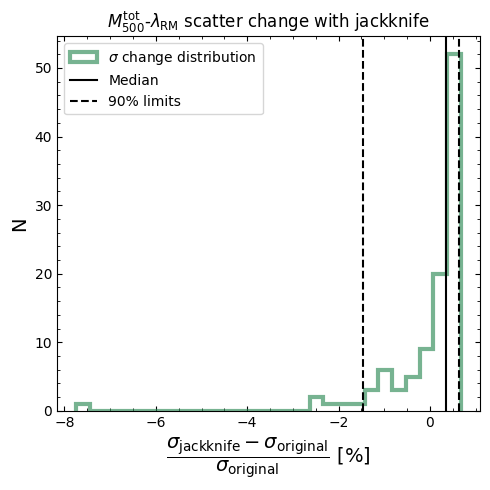

Median percentage change in scatter of 0.36%
90% confidence limits on percentage change in scatter of -1.47% to 0.64%



In [13]:
plt.figure(figsize=(5, 5))

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

# Plotting the distribution of percentage change in scatter values
plt.hist(l1_mtot500_rich_res['scatter_perc_change'].values, bins='auto', color='seagreen', alpha=0.65, 
         label=r"$\sigma$ change distribution", histtype='step', linewidth=3)

# Calculating the median and specified confidence intervals
cur_med = np.median(l1_mtot500_rich_res['scatter_perc_change'].values)
cur_low = np.percentile(l1_mtot500_rich_res['scatter_perc_change'].values, (50-(CONF_PERC/2)))
cur_upp = np.percentile(l1_mtot500_rich_res['scatter_perc_change'].values, (50+(CONF_PERC/2)))

plt.axvline(cur_med, color='black', label='Median')
plt.axvline(cur_low, color='black', linestyle='dashed', label='{}% limits'.format(CONF_PERC))
plt.axvline(cur_upp, color='black', linestyle='dashed')


plt.title(r'$M^{\rm{tot}}_{500}$-$\lambda_{\rm{RM}}$ scatter change with jackknife')
plt.ylabel('N', fontsize=14)
plt.xlabel(r'$\dfrac{\sigma_{\rm{jackknife}}-\sigma_{\rm{original}}}{\sigma_{\rm{original}}}$ [%]', fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

print("Median percentage change in scatter of {v:.2f}%".format(v=cur_med))
print("{c}% confidence limits on percentage change in scatter of {l:.2f}% to "\
      "{u:.2f}%\n".format(c=CONF_PERC, l=cur_low, u=cur_upp))

#### Selecting 'scatter-dominating' clusters

In [14]:
l1_mtot500_rich_domin = l1_mtot500_rich_res[l1_mtot500_rich_res['scatter_perc_change'] < cur_low]
l1_mtot500_rich_domin

,dropped_cluster,slope,slope+-,norm,norm+-,scatter,scatter+-,scatter_perc_change
32,SDSSXCS-210,0.6724,0.1005,5.6338,0.3970,0.2396,0.0196,-2.092
34,SDSSXCS-22,0.6949,0.0963,5.7418,0.3851,0.2258,0.0191,-7.742
36,SDSSXCS-2282,0.6345,0.1014,5.5498,0.3886,0.2400,0.0197,-1.938
79,SDSSXCS-586,0.6618,0.1009,5.6006,0.3947,0.2411,0.0197,-1.491
86,SDSSXCS-6955,0.6285,0.1010,5.5454,0.3886,0.2386,0.0195,-2.491
94,SDSSXCS-8060,0.6982,0.1020,5.5437,0.3870,0.2387,0.0197,-2.459


#### Fitting a new version of the relation without the 'scatter-dominating' clusters

In [15]:
cur_samp_wo_domin = sdssxcs_samp_with_gm500[~sdssxcs_samp_with_gm500['name'].isin(l1_mtot500_rich_domin['dropped_cluster'].values)]

# Setting up property variables in astropy quantity objects
mtot500 = Quantity(cur_samp_wo_domin[['Mhy500_wraderr', 'Mhy500_wraderr-', 'Mhy500_wraderr+']].values*1e+14, 'Msun')
rich = Quantity(cur_samp_wo_domin[['richness', 'richness_err','richness_err']].values, '')

mtot500_rich_wo_domin = scaling_relation_lira(mtot500[:, 0], mtot500[:, 1:], rich[:, 0], rich[:, 1:], m_norm, rich_norm, 
                                              y_name=r"$M^{\rm{tot}}_{500}$", x_name=r"$\lambda_{\rm{RM}}$", 
                                              point_names=cur_samp_wo_domin['name'].values)
mtot500_rich_wo_domin.model_colour = 'goldenrod'
mtot500_rich_wo_domin.author = 'Turner et al.'
mtot500_rich_wo_domin.year = 2025
mtot500_rich_wo_domin.name = r"Turner et al. '$\sigma$ dominating excluded' $M^{\rm{tot}}_{500}$-$\lambda_{\rm{RM}}$"

  |**************************************************| 100%


In [16]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot500_rich_wo_domin.pars[0][0], e=mtot500_rich_wo_domin.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot500_rich_wo_domin.pars[1][0], e=mtot500_rich_wo_domin.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot500_rich_wo_domin.scatter_par[0], e=mtot500_rich_wo_domin.scatter_par[1]))

Slope of 0.702 ± 0.087

Normalisation of 5.976 ± 0.353

Scatter of 0.193 ± 0.017


### Assessing the $M^{\rm{tot}}_{2500}$-$\lambda_{\rm{RM}}$ relation

In [17]:
l1_mtot2500_rich_rels, l1_mtot2500_rich_res = leave_one_jackknife(sdssxcs_samp_with_gm2500, mtot2500_rich, 
                                                                  x_cols=['richness', 'richness_err', 'richness_err'], 
                                                                  x_name=r"$\lambda_{\rm{RM}}$", x_norm=rich_norm, dim_hubb_ind=0,
                                                                  y_name=r"$M^{\rm{tot}}_{2500}$")

Fitting sub-sample scaling relations:   0%|                                            | 0/91 [00:00<?, ?it/s]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   1%|▍                                   | 1/91 [00:26<39:47, 26.53s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   2%|▊                                   | 2/91 [00:53<39:22, 26.55s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   3%|█▏                                  | 3/91 [01:19<38:54, 26.53s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   4%|█▌                                  | 4/91 [01:46<38:27, 26.52s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   5%|█▉                                  | 5/91 [02:13<38:12, 26.66s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   7%|██▎                                 | 6/91 [02:39<37:54, 26.76s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   8%|██▊                                 | 7/91 [03:07<37:48, 27.01s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   9%|███▏                                | 8/91 [03:34<37:21, 27.01s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  10%|███▌                                | 9/91 [04:01<36:49, 26.94s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  11%|███▊                               | 10/91 [04:28<36:32, 27.06s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  12%|████▏                              | 11/91 [04:55<36:04, 27.05s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  13%|████▌                              | 12/91 [05:22<35:28, 26.94s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  14%|█████                              | 13/91 [05:49<35:11, 27.06s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  15%|█████▍                             | 14/91 [06:17<34:58, 27.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  16%|█████▊                             | 15/91 [06:45<34:45, 27.44s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  18%|██████▏                            | 16/91 [07:13<34:25, 27.54s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  19%|██████▌                            | 17/91 [07:40<33:50, 27.44s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  20%|██████▉                            | 18/91 [08:07<33:22, 27.44s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  21%|███████▎                           | 19/91 [08:34<32:50, 27.37s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  22%|███████▋                           | 20/91 [09:02<32:25, 27.40s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  23%|████████                           | 21/91 [09:30<32:04, 27.50s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  24%|████████▍                          | 22/91 [09:57<31:34, 27.45s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  25%|████████▊                          | 23/91 [10:24<31:07, 27.46s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  26%|█████████▏                         | 24/91 [10:52<30:37, 27.43s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  27%|█████████▌                         | 25/91 [11:19<30:08, 27.41s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  29%|██████████                         | 26/91 [11:47<29:44, 27.46s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  30%|██████████▍                        | 27/91 [12:15<29:30, 27.66s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  31%|██████████▊                        | 28/91 [12:42<29:00, 27.62s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  32%|███████████▏                       | 29/91 [13:10<28:29, 27.57s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  33%|███████████▌                       | 30/91 [13:37<27:55, 27.46s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  34%|███████████▉                       | 31/91 [14:04<27:23, 27.39s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  35%|████████████▎                      | 32/91 [14:32<27:03, 27.52s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  36%|████████████▋                      | 33/91 [14:59<26:32, 27.47s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  37%|█████████████                      | 34/91 [15:27<26:05, 27.47s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  38%|█████████████▍                     | 35/91 [15:55<25:44, 27.59s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  40%|█████████████▊                     | 36/91 [16:22<25:18, 27.61s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  41%|██████████████▏                    | 37/91 [16:50<24:43, 27.47s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  42%|██████████████▌                    | 38/91 [17:17<24:19, 27.55s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  43%|███████████████                    | 39/91 [17:46<24:09, 27.87s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  44%|███████████████▍                   | 40/91 [18:13<23:32, 27.70s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  45%|███████████████▊                   | 41/91 [18:40<22:58, 27.57s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  46%|████████████████▏                  | 42/91 [19:08<22:31, 27.59s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  47%|████████████████▌                  | 43/91 [19:35<21:59, 27.49s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  48%|████████████████▉                  | 44/91 [20:03<21:37, 27.61s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  49%|█████████████████▎                 | 45/91 [20:31<21:18, 27.80s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  51%|█████████████████▋                 | 46/91 [21:00<20:56, 27.93s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  52%|██████████████████                 | 47/91 [21:27<20:19, 27.71s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  53%|██████████████████▍                | 48/91 [21:55<19:50, 27.69s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  54%|██████████████████▊                | 49/91 [22:23<19:32, 27.91s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  55%|███████████████████▏               | 50/91 [22:51<19:07, 27.99s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  56%|███████████████████▌               | 51/91 [23:19<18:40, 28.02s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  57%|████████████████████               | 52/91 [23:47<18:07, 27.89s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  58%|████████████████████▍              | 53/91 [24:15<17:44, 28.00s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  59%|████████████████████▊              | 54/91 [24:42<17:08, 27.79s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  60%|█████████████████████▏             | 55/91 [25:10<16:35, 27.65s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  62%|█████████████████████▌             | 56/91 [25:37<16:05, 27.57s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  63%|█████████████████████▉             | 57/91 [26:04<15:30, 27.37s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  64%|██████████████████████▎            | 58/91 [26:31<15:00, 27.30s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  65%|██████████████████████▋            | 59/91 [26:58<14:29, 27.17s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  66%|███████████████████████            | 60/91 [27:25<13:57, 27.01s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  67%|███████████████████████▍           | 61/91 [27:51<13:28, 26.94s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  68%|███████████████████████▊           | 62/91 [28:20<13:12, 27.31s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  69%|████████████████████████▏          | 63/91 [28:47<12:43, 27.28s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  70%|████████████████████████▌          | 64/91 [29:14<12:18, 27.36s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  71%|█████████████████████████          | 65/91 [29:41<11:48, 27.24s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  73%|█████████████████████████▍         | 66/91 [30:09<11:21, 27.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  74%|█████████████████████████▊         | 67/91 [30:35<10:50, 27.12s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  75%|██████████████████████████▏        | 68/91 [31:03<10:24, 27.14s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  76%|██████████████████████████▌        | 69/91 [31:30<09:57, 27.17s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  77%|██████████████████████████▉        | 70/91 [31:57<09:29, 27.13s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  78%|███████████████████████████▎       | 71/91 [32:24<09:01, 27.05s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  79%|███████████████████████████▋       | 72/91 [32:51<08:36, 27.20s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  80%|████████████████████████████       | 73/91 [33:18<08:07, 27.06s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  81%|████████████████████████████▍      | 74/91 [33:45<07:39, 27.01s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  82%|████████████████████████████▊      | 75/91 [34:12<07:13, 27.11s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  84%|█████████████████████████████▏     | 76/91 [34:39<06:45, 27.03s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  85%|█████████████████████████████▌     | 77/91 [35:06<06:19, 27.08s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  86%|██████████████████████████████     | 78/91 [35:33<05:51, 27.07s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  87%|██████████████████████████████▍    | 79/91 [36:00<05:24, 27.00s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  88%|██████████████████████████████▊    | 80/91 [36:27<04:57, 27.01s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  89%|███████████████████████████████▏   | 81/91 [36:54<04:30, 27.04s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  90%|███████████████████████████████▌   | 82/91 [37:22<04:03, 27.10s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  91%|███████████████████████████████▉   | 83/91 [37:49<03:37, 27.13s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  92%|████████████████████████████████▎  | 84/91 [38:16<03:09, 27.05s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  93%|████████████████████████████████▋  | 85/91 [38:43<02:42, 27.04s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  95%|█████████████████████████████████  | 86/91 [39:10<02:15, 27.04s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  96%|█████████████████████████████████▍ | 87/91 [39:37<01:48, 27.08s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  97%|█████████████████████████████████▊ | 88/91 [40:04<01:21, 27.08s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  98%|██████████████████████████████████▏| 89/91 [40:31<00:53, 27.00s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  99%|██████████████████████████████████▌| 90/91 [40:58<00:26, 26.98s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations: 100%|███████████████████████████████████| 91/91 [41:25<00:00, 27.32s/it]


One of the outputs of the jackknifing function is a dataframe containing the relation parameters linked to the name of the cluster that was excluded in each case - we save them to disk as well as making use of them later to measure scaling relations with the scatter-dominating clusters removed.

In [18]:
l1_mtot2500_rich_res.to_csv("../../outputs/result_files/exploring_scatter/leave_one_jackknife/mtot-richness/"\
                            "mtot2500_richness_l1_jackknife_rel_pars.csv")
l1_mtot2500_rich_res.head(6)

,dropped_cluster,slope,slope+-,norm,norm+-,scatter,scatter+-,scatter_perc_change
0,SDSSXCS-1018,0.6623,0.1153,5.4218,0.4549,0.2630,0.0228,30.527
1,SDSSXCS-10401,0.6302,0.1158,5.4296,0.4495,0.2590,0.0226,28.553
2,SDSSXCS-110,0.6586,0.1146,5.3822,0.4499,0.2604,0.0226,29.214
3,SDSSXCS-11154,0.6687,0.1168,5.4380,0.4556,0.2632,0.0228,30.601
4,SDSSXCS-1131,0.6614,0.1150,5.4521,0.4564,0.2618,0.0226,29.922
5,SDSSXCS-11331,0.6609,0.1166,5.4374,0.4557,0.2635,0.0228,30.769


#### Diagnostic distribution of percentage change of scatter

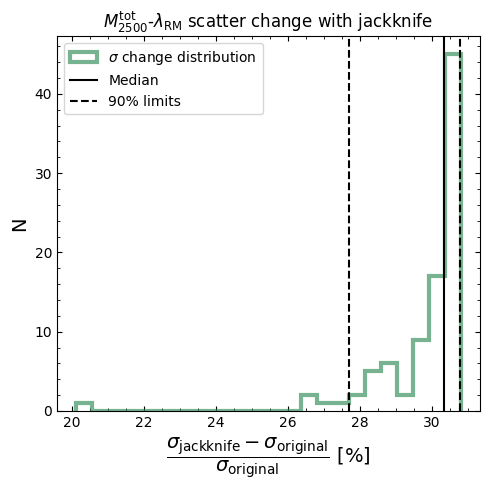

Median percentage change in scatter of 30.33%
90% confidence limits on percentage change in scatter of 27.68% to 30.76%



In [19]:
plt.figure(figsize=(5, 5))

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

# Plotting the distribution of percentage change in scatter values
plt.hist(l1_mtot2500_rich_res['scatter_perc_change'].values, bins='auto', color='seagreen', alpha=0.65, 
         label=r"$\sigma$ change distribution", histtype='step', linewidth=3)

# Calculating the median and specified confidence intervals
cur_med = np.median(l1_mtot2500_rich_res['scatter_perc_change'].values)
cur_low = np.percentile(l1_mtot2500_rich_res['scatter_perc_change'].values, (50-(CONF_PERC/2)))
cur_upp = np.percentile(l1_mtot2500_rich_res['scatter_perc_change'].values, (50+(CONF_PERC/2)))

plt.axvline(cur_med, color='black', label='Median')
plt.axvline(cur_low, color='black', linestyle='dashed', label='{}% limits'.format(CONF_PERC))
plt.axvline(cur_upp, color='black', linestyle='dashed')


plt.title(r'$M^{\rm{tot}}_{2500}$-$\lambda_{\rm{RM}}$ scatter change with jackknife')
plt.ylabel('N', fontsize=14)
plt.xlabel(r'$\dfrac{\sigma_{\rm{jackknife}}-\sigma_{\rm{original}}}{\sigma_{\rm{original}}}$ [%]', fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

print("Median percentage change in scatter of {v:.2f}%".format(v=cur_med))
print("{c}% confidence limits on percentage change in scatter of {l:.2f}% to "\
      "{u:.2f}%\n".format(c=CONF_PERC, l=cur_low, u=cur_upp))

#### Selecting 'scatter-dominating' clusters

In [20]:
l1_mtot2500_rich_domin = l1_mtot2500_rich_res[l1_mtot2500_rich_res['scatter_perc_change'] < cur_low]
l1_mtot2500_rich_domin

,dropped_cluster,slope,slope+-,norm,norm+-,scatter,scatter+-,scatter_perc_change
26,SDSSXCS-210,0.6801,0.1128,5.5621,0.4581,0.2562,0.0222,27.138
28,SDSSXCS-22,0.7041,0.1082,5.6814,0.4470,0.2420,0.0217,20.117
30,SDSSXCS-2282,0.6379,0.1135,5.4591,0.4469,0.2569,0.0224,27.490
74,SDSSXCS-6955,0.6305,0.1130,5.4528,0.4445,0.2552,0.0221,26.654
82,SDSSXCS-8060,0.7068,0.1143,5.4590,0.4441,0.2550,0.0223,26.542


#### Fitting a new version of the relation without the 'scatter-dominating' clusters

In [21]:
cur_samp_wo_domin = sdssxcs_samp_with_gm500[~sdssxcs_samp_with_gm500['name'].isin(l1_mtot2500_rich_domin['dropped_cluster'].values)]

# Setting up property variables in astropy quantity objects
mtot2500 = Quantity(cur_samp_wo_domin[['Mhy2500_wraderr', 'Mhy2500_wraderr-', 'Mhy2500_wraderr+']].values*1e+14, 'Msun')
rich = Quantity(cur_samp_wo_domin[['richness', 'richness_err','richness_err']].values, '')

mtot2500_rich_wo_domin = scaling_relation_lira(mtot2500[:, 0], mtot2500[:, 1:], rich[:, 0], rich[:, 1:], m_norm, rich_norm, 
                                               y_name=r"$M^{\rm{tot}}_{2500}$", x_name=r"$\lambda_{\rm{RM}}$", 
                                               point_names=cur_samp_wo_domin['name'].values)
mtot2500_rich_wo_domin.model_colour = 'dodgerblue'
mtot2500_rich_wo_domin.author = 'Turner et al.'
mtot2500_rich_wo_domin.year = 2025
mtot2500_rich_wo_domin.name = r"Turner et al. '$\sigma$ dominating excluded' $M^{\rm{tot}}_{2500}$-$\lambda_{\rm{RM}}$"

/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:414: UserWarning: 13 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, True, point_names,


  |**************************************************| 100%


/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:450: UserWarning: 13 sources have NaN values or negative uncertainties and have been excluded
  throw_away, sec_throw_away = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm)


In [22]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_rich_wo_domin.pars[0][0], e=mtot2500_rich_wo_domin.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_rich_wo_domin.pars[1][0], e=mtot2500_rich_wo_domin.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot2500_rich_wo_domin.scatter_par[0], e=mtot2500_rich_wo_domin.scatter_par[1]))

Slope of 0.690 ± 0.090

Normalisation of 1.927 ± 0.124

Scatter of 0.199 ± 0.018
